In [1]:
!pip install --quiet pennylane

In [2]:
import numpy as np
import pandas as pd
import pennylane as qml
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from numpy import pi

In [3]:
df=pd.read_csv("/kaggle/input/breast-cancer-wisconsin-data/data.csv")
df.drop(["id","Unnamed: 32"],axis=1,inplace=True)
LabelEncoder=LabelEncoder()
df.diagnosis=LabelEncoder.fit_transform(df.diagnosis)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
unique_values=df['diagnosis'].unique()
print(unique_values)

[1 0]


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('diagnosis', axis=1), df['diagnosis'], test_size=0.2, random_state=42)

In [6]:
chi_ls = []

for feature in X_train.columns:
    
    # create contingency table
    c = pd.crosstab(y_train, X_train[feature])
    
    # chi_test
    p_value = chi2_contingency(c)[1]
    chi_ls.append(p_value)

Text(0.5, 1.0, 'Feature importance based on chi-square test')

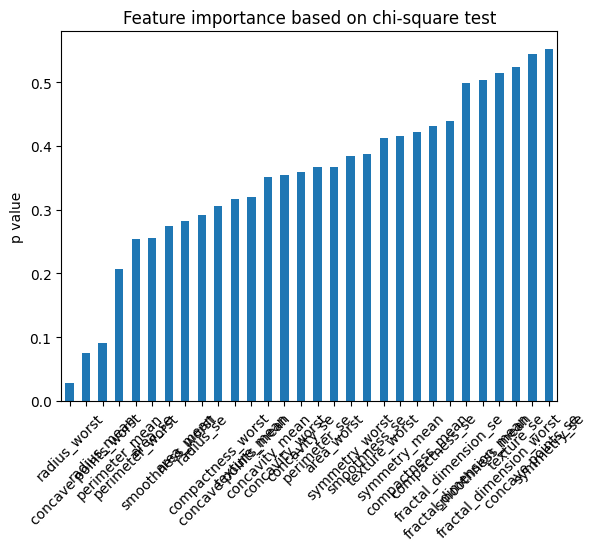

In [7]:
import matplotlib.pyplot as plt
pd.Series(chi_ls, index=X_train.columns).sort_values(ascending=True).plot.bar(rot=45)
plt.ylabel('p value')
plt.title('Feature importance based on chi-square test')

In [8]:
# select top 4

selected = pd.Series(chi_ls, index=X_train.columns).sort_values(
    ascending=True)[0:4].index

selected

Index(['radius_worst', 'concave points_worst', 'radius_mean',
       'perimeter_mean'],
      dtype='object')

In [9]:

X_train = X_train[selected]
X_test = X_test[selected]

X_train.head()

,radius_worst,concave points_worst,radius_mean,perimeter_mean
68,10.31,0.17500,9.029,58.79
181,26.68,0.29030,21.090,142.70
63,10.01,0.05087,9.173,59.20
248,12.25,0.06136,10.650,68.01
60,11.02,0.02579,10.170,64.55


In [10]:

X_test.head()

,radius_worst,concave points_worst,radius_mean,perimeter_mean
204,14.97,0.10150,12.47,81.09
70,24.86,0.17890,18.94,123.60
131,19.26,0.15140,15.46,101.70
431,12.88,0.07370,12.40,81.47
540,12.26,0.06918,11.54,74.65


In [11]:
from sklearn.preprocessing import MinMaxScaler
mms=MinMaxScaler()
X_train=mms.fit_transform(X_train)
X_test=mms.fit_transform(X_test)


In [12]:
X_train

array([[0.05964476, 0.60137457, 0.06552721, 0.07732252],
       [0.65791974, 0.9975945 , 0.65620256, 0.67420686],
       [0.04868065, 0.174811  , 0.07257946, 0.08023901],
       ...,
       [0.22776113, 0.11453608, 0.32317939, 0.30146536],
       [0.30560632, 0.62783505, 0.30799745, 0.30729834],
       [0.17038228, 0.25536082, 0.21984426, 0.20842225]])

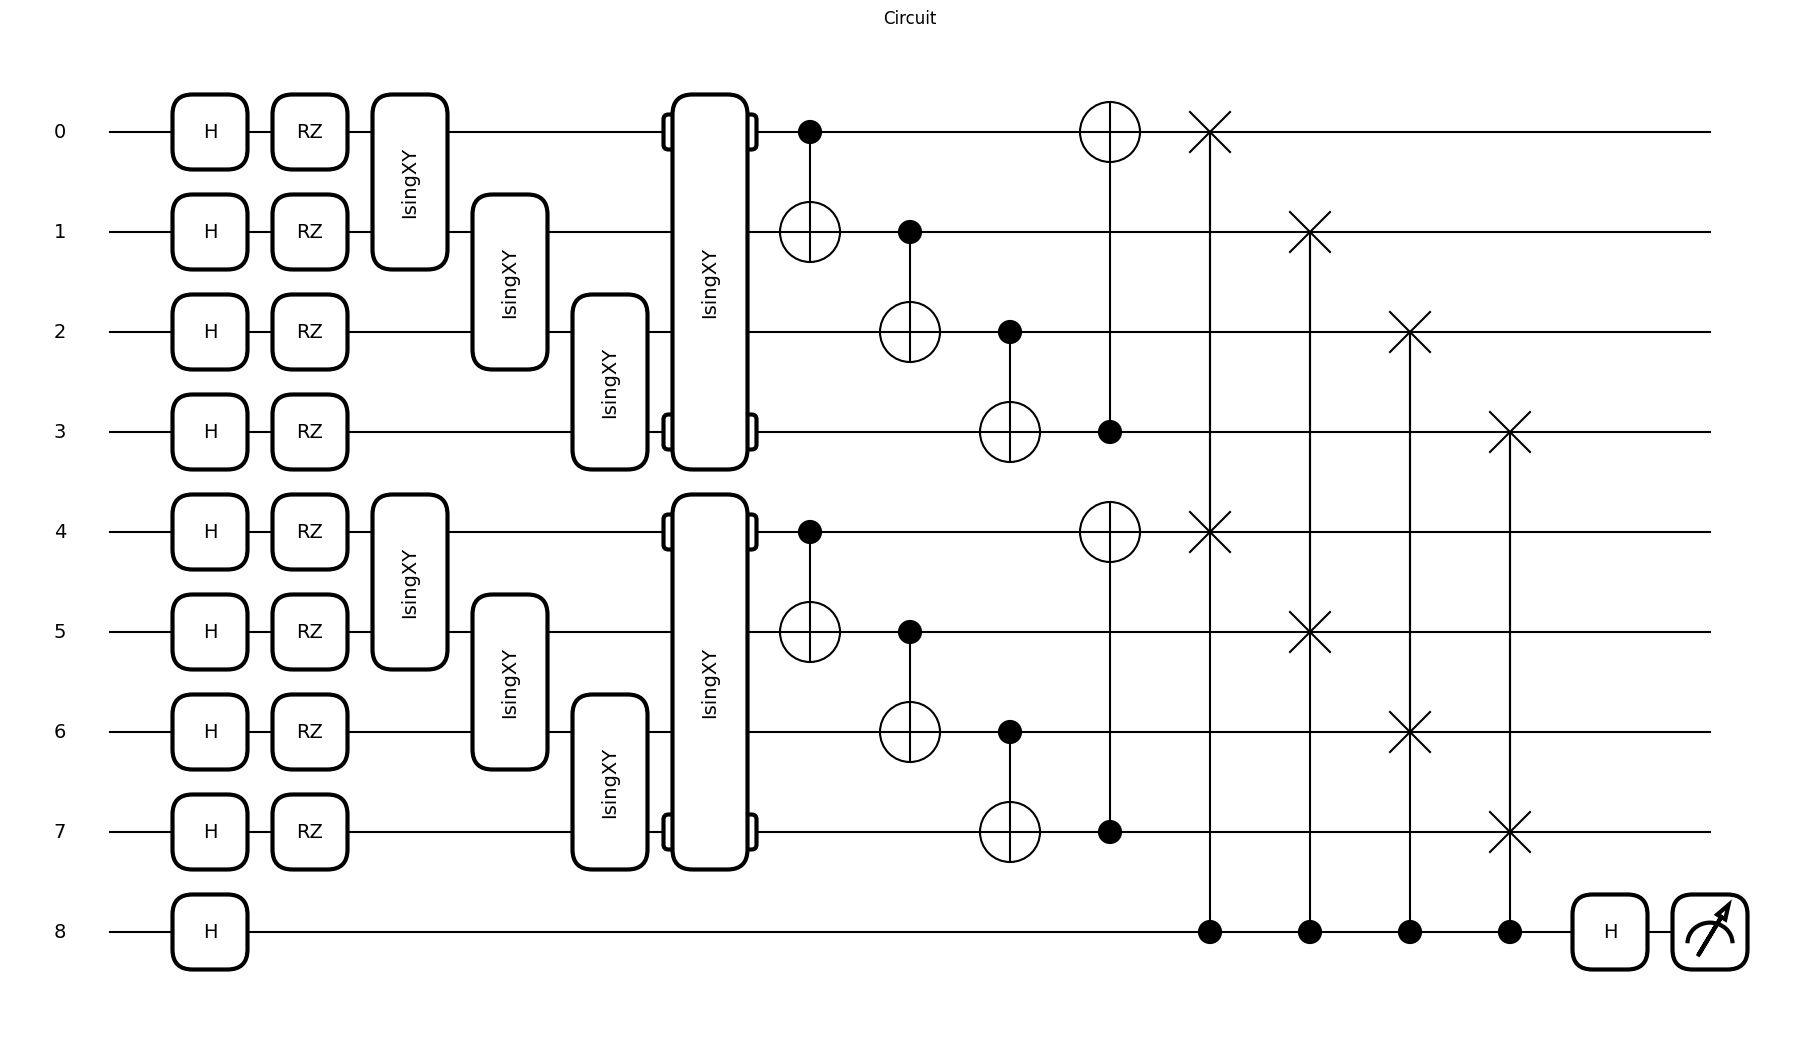

In [13]:
dev=qml.device("lightning.qubit",wires=9)

@qml.qnode(dev)
def circuit(x_train,x_test):
    for i in range(len(x_train)*2):
        qml.Hadamard(wires=i)
    
    qml.Hadamard(wires=(len(x_train)*2))
    
    #qml.Barrier(wires=(len(x_train)*2)+1)
        
    for i in range(len(x_train)):
            qml.RZ(x_train[i],wires=i)
            
    
    for i in range(len(x_test)):
            qml.RZ(x_test[i],wires=i+len(x_train))
            
    for i in range(len(x_train)):        
            if i==len(x_train)-1:
                qml.IsingXY(pi/3,wires=[i,i-len(x_train)+1])
            else:
                qml.IsingXY(pi/3,wires=[i,i+1])
            
    for i in range(len(x_test)): 
            
            if i==len(x_test)-1:
                qml.IsingXY(pi/3,wires=[i+len(x_train),i+1])
            else:
                qml.IsingXY(pi/3,wires=[i+len(x_train),i+1+len(x_train)])
                
    for i in range(len(x_train)):        
            if i==len(x_train)-1:
                qml.CNOT(wires=[i,i-len(x_train)+1])
            else:
                qml.CNOT(wires=[i,i+1])
    for i in range(len(x_test)): 
            
            if i==len(x_test)-1:
                qml.CNOT(wires=[i+len(x_train),i+1])
            else:
                qml.CNOT(wires=[i+len(x_train),i+1+len(x_train)])
                
    for i in range(len(x_train)):
        qml.CSWAP(wires=[(len(x_train)*2),i,i+len(x_train)])
        
    
    qml.Hadamard(wires=(len(x_train)*2))
        
    return qml.expval(qml.PauliZ(8))
    #return qml.probs(wires=(len(x_train)*2))

fig, ax = qml.draw_mpl(circuit)(X_train[0],X_test[0])
ax.set_title("Circuit")
plt.show()

In [14]:
result=circuit(X_train[0],X_test[1])
print(result)

0.767032388616311


In [15]:
y_train=y_train.to_numpy()
y_test=y_test.to_numpy()

In [16]:
y_train[0]

0

In [17]:
y_test[0]

0

In [18]:
prediction=[]
for j in range(len(X_test)):
    a=[]
    for i in range(len(X_train)):
        if circuit(X_train[i],X_test[j])>0.99:
            a.append(y_train[i])
        
    count_0=a.count(0)
    count_1=a.count(1)
    if count_0>count_1:
        prediction.append(0)
    else:
        prediction.append(1)

In [19]:
#prediction
prediction_n=np.array(prediction)

In [20]:
from sklearn.metrics import accuracy_score

accuracy=accuracy_score(y_test,prediction_n)
print(accuracy)

0.9824561403508771


In [25]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test,prediction_n)
print(f"AUC: {auc}")

AUC: 0.9859154929577465


In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
print("\nClassification Report:")
print(classification_report(y_test, prediction_n))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        71
           1       0.96      1.00      0.98        43

    accuracy                           0.98       114
   macro avg       0.98      0.99      0.98       114
weighted avg       0.98      0.98      0.98       114



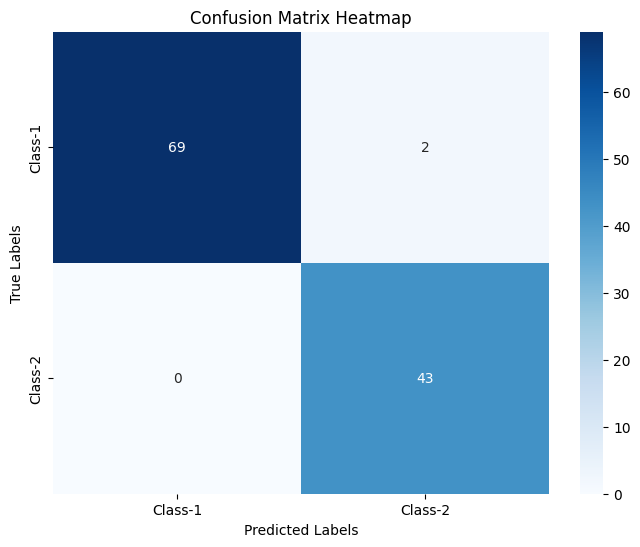

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, prediction_n)
class_names = ['Class-1', 'Class-2'] 

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Classical KNN

In [21]:
from sklearn.neighbors import KNeighborsRegressor


# Create and train the KNN regressor
knn_regressor = KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = knn_regressor.predict(X_test)

# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

In [22]:
accuracy=accuracy_score(y_test,y_pred_binary)
print(accuracy)

0.9298245614035088
